In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize']=10,6
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import math
import seaborn as sns

import tensorflow as tf
tf.random.set_seed(42)



2024-05-21 20:40:35.042340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 20:40:35.042476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 20:40:35.207162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check data in input directory after linking dataset
import os
print(os.listdir("../input/rainfall-in-india"))

['rainfall in india 1901-2015.csv', 'district wise rainfall normal.csv']


In [3]:
rainfall_data=pd.read_csv("../input/rainfall-in-india/rainfall in india 1901-2015.csv",encoding = "ISO-8859-1")
rainfall_data.dtypes
df=rainfall_data

In [4]:
# Find coulmns with missing data in data frames
def coulmn_with_missing_valies(df):
    columns_with_missing_values = [col for col in df.columns if df[col].isnull().any()]
    #print(columns_with_missing_values)
    return columns_with_missing_values

In [5]:
# print(coulmn_with_missing_valies(rainfall_data))
df.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
4111    False
4112    False
4113    False
4114    False
4115    False
Length: 4116, dtype: bool

In [6]:
rainfall_data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [7]:
rainfall_data.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
count,4116.000000,4112.000000,4113.000000,4110.000000,4112.000000,4113.000000,4111.000000,4109.000000,4112.000000,4110.000000,4109.000000,4105.000000,4106.000000,4090.000000,4110.000000,4107.000000,4106.000000,4103.000000
mean,1958.218659,18.957320,21.805325,27.359197,43.127432,85.745417,230.234444,347.214334,290.263497,197.361922,95.507009,39.866163,18.870580,1411.008900,40.747786,155.901753,1064.724769,154.100487
std,33.140898,33.585371,35.909488,46.959424,67.831168,123.234904,234.710758,269.539667,188.770477,135.408345,99.519134,68.685410,42.369611,903.846565,59.308277,201.316965,707.741531,166.942660
min,1901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,62.300000,0.000000,0.000000,57.400000,0.000000
25%,1930.000000,0.600000,0.600000,1.000000,3.000000,8.600000,70.350000,175.600000,155.975000,100.525000,14.600000,0.700000,0.100000,804.500000,4.100000,24.050000,573.850000,34.200000
50%,1958.000000,6.000000,6.700000,7.800000,15.700000,36.600000,138.700000,284.800000,259.400000,173.900000,65.200000,9.500000,3.000000,1121.300000,19.200000,74.800000,881.100000,98.200000
75%,1987.000000,22.200000,26.800000,31.300000,49.950000,97.200000,305.150000,418.400000,377.800000,265.800000,148.400000,46.100000,17.500000,1644.775000,50.375000,196.950000,1288.175000,213.500000
max,2015.000000,583.700000,403.500000,605.600000,595.100000,1168.600000,1609.900000,2362.800000,1664.600000,1222.000000,948.300000,648.900000,617.500000,6331.100000,699.500000,1745.800000,4536.900000,1252.500000


In [8]:
rainfall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUBDIVISION  4116 non-null   object 
 1   YEAR         4116 non-null   int64  
 2   JAN          4112 non-null   float64
 3   FEB          4113 non-null   float64
 4   MAR          4110 non-null   float64
 5   APR          4112 non-null   float64
 6   MAY          4113 non-null   float64
 7   JUN          4111 non-null   float64
 8   JUL          4109 non-null   float64
 9   AUG          4112 non-null   float64
 10  SEP          4110 non-null   float64
 11  OCT          4109 non-null   float64
 12  NOV          4105 non-null   float64
 13  DEC          4106 non-null   float64
 14  ANNUAL       4090 non-null   float64
 15  Jan-Feb      4110 non-null   float64
 16  Mar-May      4107 non-null   float64
 17  Jun-Sep      4106 non-null   float64
 18  Oct-Dec      4103 non-null   float64
dtypes: flo

In [9]:
dataset=rainfall_data
groups = dataset.groupby('SUBDIVISION')[['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','NOV','DEC']]
data=groups.get_group(('NORTH INTERIOR KARNATAKA'))
data.head()



,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,NOV,DEC
3657,1901,3.5,18.8,7.1,67.2,65.5,120.5,151.9,115.1,128.8,13.6,0.9
3658,1902,0.0,0.0,0.3,22.5,34.4,111.3,83.2,78.1,146.7,35.7,85.1
3659,1903,3.5,0.0,0.1,6.9,53.4,102.8,209.4,146.4,189.3,34.3,16.0
3660,1904,0.2,0.3,8.5,11.0,46.3,120.6,91.6,48.5,165.1,0.0,0.0
3661,1905,0.0,6.0,2.6,16.0,51.2,99.6,60.1,139.2,42.2,4.4,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Axes: xlabel='YEAR', ylabel='ANNUAL'>

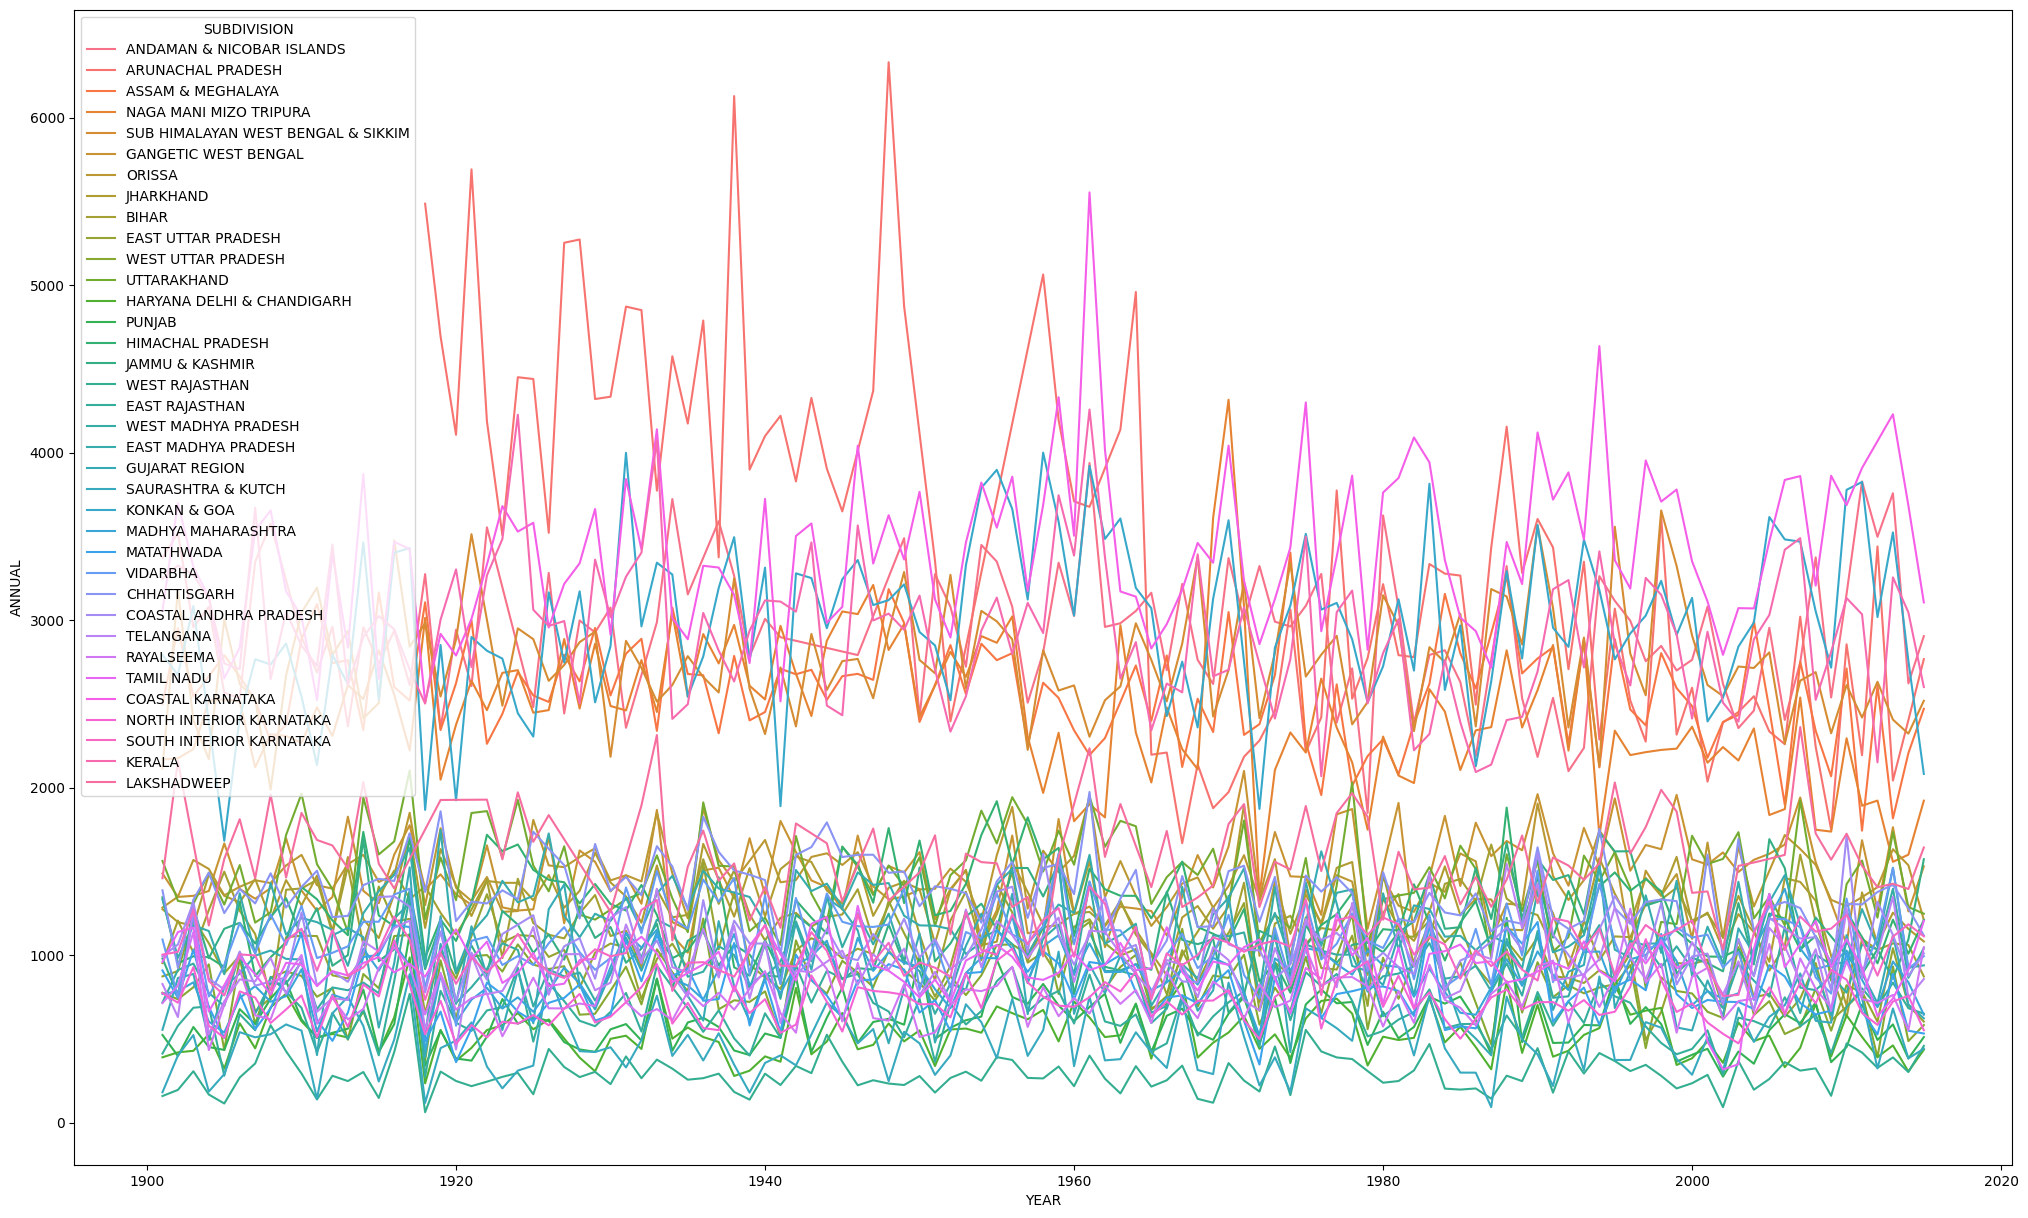

In [10]:
plt.figure(figsize=(25,15))
sns.lineplot(x = 'YEAR', y= 'ANNUAL', hue = 'SUBDIVISION', data = rainfall_data)

In [11]:
# Check all sub divisions
dataset.SUBDIVISION.unique()

array(['ANDAMAN & NICOBAR ISLANDS', 'ARUNACHAL PRADESH',
       'ASSAM & MEGHALAYA', 'NAGA MANI MIZO TRIPURA',
       'SUB HIMALAYAN WEST BENGAL & SIKKIM', 'GANGETIC WEST BENGAL',
       'ORISSA', 'JHARKHAND', 'BIHAR', 'EAST UTTAR PRADESH',
       'WEST UTTAR PRADESH', 'UTTARAKHAND', 'HARYANA DELHI & CHANDIGARH',
       'PUNJAB', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'WEST RAJASTHAN',
       'EAST RAJASTHAN', 'WEST MADHYA PRADESH', 'EAST MADHYA PRADESH',
       'GUJARAT REGION', 'SAURASHTRA & KUTCH', 'KONKAN & GOA',
       'MADHYA MAHARASHTRA', 'MATATHWADA', 'VIDARBHA', 'CHHATTISGARH',
       'COASTAL ANDHRA PRADESH', 'TELANGANA', 'RAYALSEEMA', 'TAMIL NADU',
       'COASTAL KARNATAKA', 'NORTH INTERIOR KARNATAKA',
       'SOUTH INTERIOR KARNATAKA', 'KERALA', 'LAKSHADWEEP'], dtype=object)

In [12]:
data=data.melt(['YEAR']).reset_index()
data.head()

,index,YEAR,variable,value
0,0,1901,JAN,3.5
1,1,1902,JAN,0.0
2,2,1903,JAN,3.5
3,3,1904,JAN,0.2
4,4,1905,JAN,0.0


In [13]:
df= data[['YEAR','variable','value']].reset_index().sort_values(by=['YEAR','index'])
df.head()

,index,YEAR,variable,value
0,0,1901,JAN,3.5
115,115,1901,FEB,18.8
230,230,1901,MAR,7.1
345,345,1901,APR,67.2
460,460,1901,MAY,65.5


In [14]:
df.columns=['INDEX','YEAR','Month','avg_rainfall']
df.head()


,INDEX,YEAR,Month,avg_rainfall
0,0,1901,JAN,3.5
115,115,1901,FEB,18.8
230,230,1901,MAR,7.1
345,345,1901,APR,67.2
460,460,1901,MAY,65.5


In [15]:
d={'JAN':1,'FEB':2,'MAR' :3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,
   'OCT':10,'NOV':11,'DEC':12}
df['Month']=df['Month'].map(d)
df.head(12)

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,1,3.5
115,115,1901,2,18.8
230,230,1901,3,7.1
345,345,1901,4,67.2
460,460,1901,5,65.5
575,575,1901,6,120.5
690,690,1901,7,151.9
805,805,1901,8,115.1
920,920,1901,9,128.8
1035,1035,1901,11,13.6


In [16]:
df['Date']=pd.to_datetime(df.assign(Day=1).loc[:,['YEAR','Month','Day']])
df.head(12)

,INDEX,YEAR,Month,avg_rainfall,Date
0,0,1901,1,3.5,1901-01-01
115,115,1901,2,18.8,1901-02-01
230,230,1901,3,7.1,1901-03-01
345,345,1901,4,67.2,1901-04-01
460,460,1901,5,65.5,1901-05-01
575,575,1901,6,120.5,1901-06-01
690,690,1901,7,151.9,1901-07-01
805,805,1901,8,115.1,1901-08-01
920,920,1901,9,128.8,1901-09-01
1035,1035,1901,11,13.6,1901-11-01


In [17]:
cols=['avg_rainfall']
dataset=df[cols]
dataset.head()

,avg_rainfall
0,3.5
115,18.8
230,7.1
345,67.2
460,65.5


In [18]:
series=dataset
series.head()

,avg_rainfall
0,3.5
115,18.8
230,7.1
345,67.2
460,65.5


In [19]:
series.shape


(1265, 1)

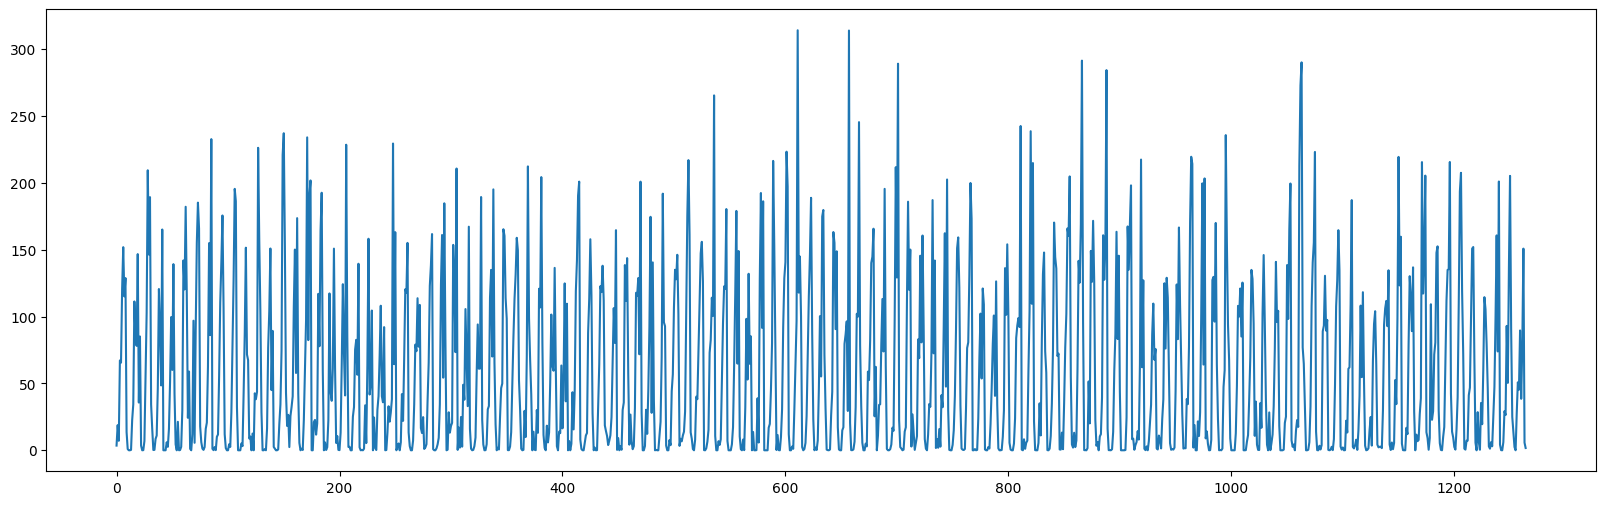

In [20]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

In [21]:
# Get the raw data values from the pandas data frame.
data_raw = series.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.01114295],
       [0.05985355],
       [0.02260427],
       [0.2139446 ],
       [0.20853232]], dtype=float32)

In [22]:
# Using 80% of data for training, 20% for validation.
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1012, 253)


In [23]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [24]:
# Create test and training sets
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(1010, 1)
New training data shape:
(1010, 1, 1)


In [25]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(2000,activation = 'tanh', recurrent_activation = 'hard_sigmoid', input_shape = (1, window_size)))
    model.add(Dropout(0.2))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(400))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 10, 
              batch_size = 64, 
              )
    
    return(model)



In [26]:
def fit_model2(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(2000,activation = 'tanh', recurrent_activation = 'hard_sigmoid', input_shape = (1, window_size)))
    model.add(Dropout(0.2))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(400))
    model.add(Dropout(0.4)) 
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 10, 
              batch_size = 64, 
              )
    
    return(model)


In [27]:
def fit_model3(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(2000,activation = 'tanh', recurrent_activation = 'relu', input_shape = (1, window_size)))
    model.add(Dropout(0.2))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(400))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 10, 
              batch_size = 64, 
              )
    
    return(model)

In [29]:
# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)
model2 = fit_model2(train_X, train_Y, window_size)
model3 = fit_model3(train_X, train_Y, window_size)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - loss: 0.0422
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - loss: 0.0342
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - loss: 0.0326
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.0345
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - loss: 0.0332
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: 0.0329
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - loss: 0.0339
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.0319
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - loss: 0.0326
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - loss: 0.0337
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - loss: 0.0417
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - loss: 0.0344
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.0331
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.0350
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0

In [32]:
def plot_predict_data(dataset,train_predict,test_predict):
    # Start with training predictions.
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

    # Add test predictions.
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

    # Create the plot.
    plt.figure(figsize = (50, 8))
    plt.plot(scaler.inverse_transform(dataset), label = "True value",color='red')
    plt.plot(train_predict_plot, label = "Training set prediction",color='green')
    plt.plot(test_predict_plot, label = "Test set prediction",color='blue')
    plt.xlabel("Months")


    plt.legend()
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Training data score: 56.26 RMSE
Test data score: 52.54 RMSE


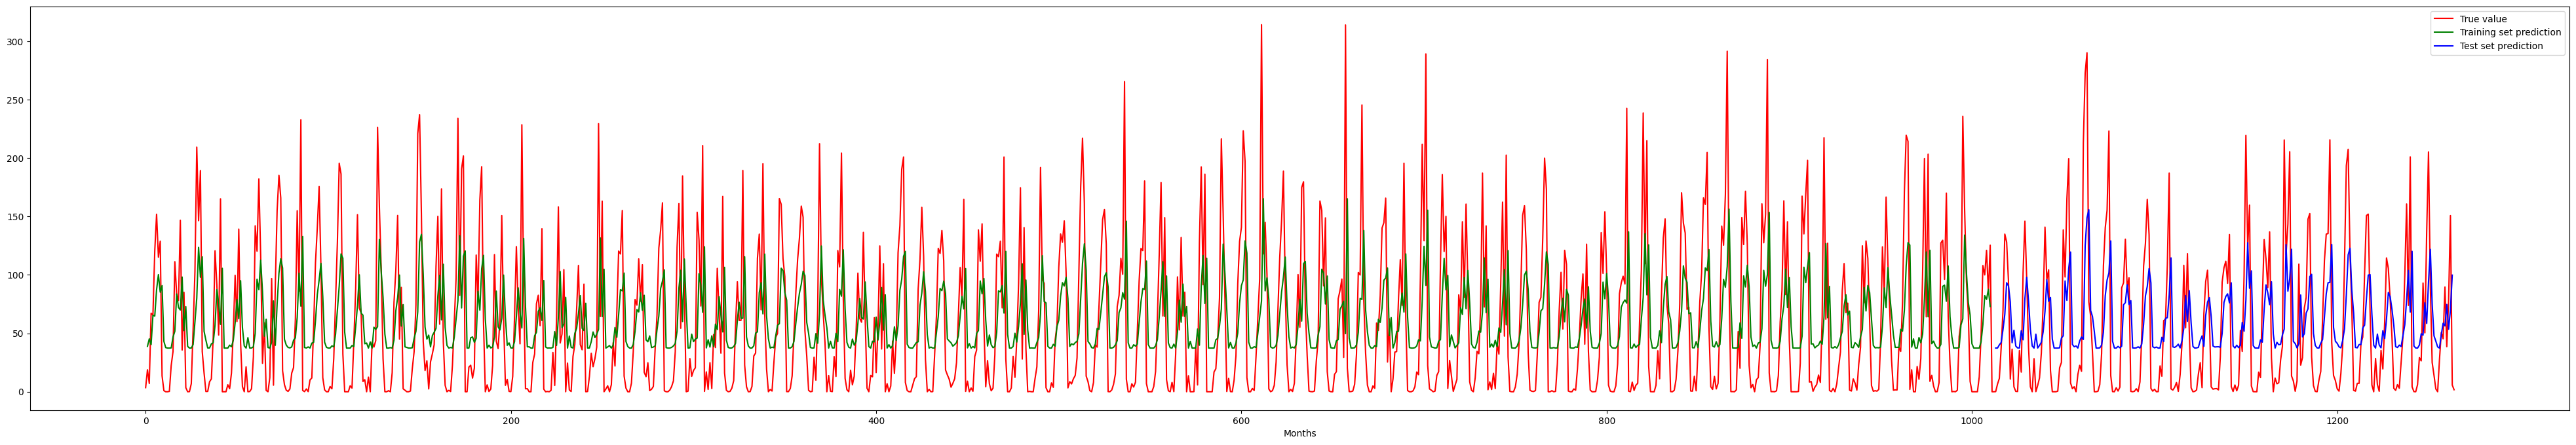

In [33]:
# Predict
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

plot_predict_data(dataset,train_predict,test_predict)

# rmse_train, train_predict = predict_and_score(model2, train_X, train_Y)
# rmse_test, test_predict = predict_and_score(model2, test_X, test_Y)

# print("Training data score: %.2f RMSE" % rmse_train)
# print("Test data score: %.2f RMSE" % rmse_test)

# plot_predict_data(dataset,train_predict,test_predict)

# # 3
# rmse_train, train_predict = predict_and_score(model3, train_X, train_Y)
# rmse_test, test_predict = predict_and_score(model3, test_X, test_Y)

# print("Training data score: %.2f RMSE" % rmse_train)
# print("Test data score: %.2f RMSE" % rmse_test)

# plot_predict_data(dataset,train_predict,test_predict)



In [34]:
train_predict

array([[38.839832],
       [45.26002 ],
       [40.352283],
       ...,
       [78.99551 ],
       [87.62789 ],
       [72.84764 ]], dtype=float32)

In [35]:
# Using GRU


import tensorflow as tf
tf.random.set_seed(42)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam




In [103]:
n_features = 2
# 80% Train, 10% Validation 10% test
n_train = int(len(dataset) * 0.80)
n_remaining = len(dataset) - n_train

n_val = int(n_remaining*0.50)
n_test = n_remaining - n_val 
print("Train samples:",n_train, "Validation Samples:",n_val,"Test Samples:", n_test)
train_data = dataset[0:n_train]
print(train_data.shape)
val_data = dataset[n_train:n_train+n_val]
print(val_data.shape)

test_data = dataset[n_train-2:]
print(test_data.shape)

trainX, trainY = create_dataset(train_data, n_features)
valX, valY = create_dataset(val_data, n_features)
testX, testY = create_dataset(test_data, n_features)

trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
valX = valX.reshape(valX.shape[0] , 1 ,valX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

print(trainX.shape , trainY.shape , valX.shape , valY.shape, testX.shape , testY.shape)



Train samples: 1012 Validation Samples: 126 Test Samples: 127
(1012, 1)
(126, 1)
(255, 1)
(1009, 1, 2) (1009,) (123, 1, 2) (123,) (252, 1, 2) (252,)


In [107]:

model = keras.Sequential()

# First GRU layer
model.add(layers.GRU(units=100, return_sequences=True, input_shape=(1,n_features), activation='tanh'))
model.add(layers.Dropout(0.2))

# Second GRU layer
model.add(layers.GRU(units=150, return_sequences=True, input_shape=(1,n_features), activation='tanh'))
model.add(layers.Dropout(0.2))

# Third GRU layer
model.add(layers.GRU(units=100, activation='tanh'))
model.add(layers.Dropout(0.2))

# The output layer
model.add(layers.Dense(units=1, kernel_initializer='he_uniform', activation='linear'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
model.compile(loss='mean_squared_error', optimizer=Adam(0.0005) , metrics = ['mean_squared_error'])

In [110]:
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 1, 100)         │        31,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 1, 150)         │       113,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 100)            │        75,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,301 (860.55 KB)

 Trainable params: 220,301 (860.55 KB)

 Non-trainable params: 0 (0.00 B)

None


In [111]:
history = model.fit(trainX,trainY,epochs=100,batch_size=128, verbose=1, validation_data = (valX,valY))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0323 - mean_squared_error: 0.0322 - val_loss: 0.0262 - val_mean

In [112]:
import math

def model_score(model, X_train, y_train, X_val, y_val , X_test, y_test):
    print('Train Score:')
    train_score = model.evaluate(X_train, y_train, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format(train_score[0], math.sqrt(train_score[0])))

    print('Validation Score:')
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format (val_score[0], math.sqrt(val_score[0])))

    print('Test Score:')
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format (test_score[0], math.sqrt(test_score[0])))


model_score(model, trainX, trainY ,valX, valY , testX, testY)

Train Score:
MSE: 0.02465 , RMSE: 0.16
Validation Score:
MSE: 0.02520 , RMSE: 0.16
Test Score:
MSE: 0.02378 , RMSE: 0.15


In [113]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


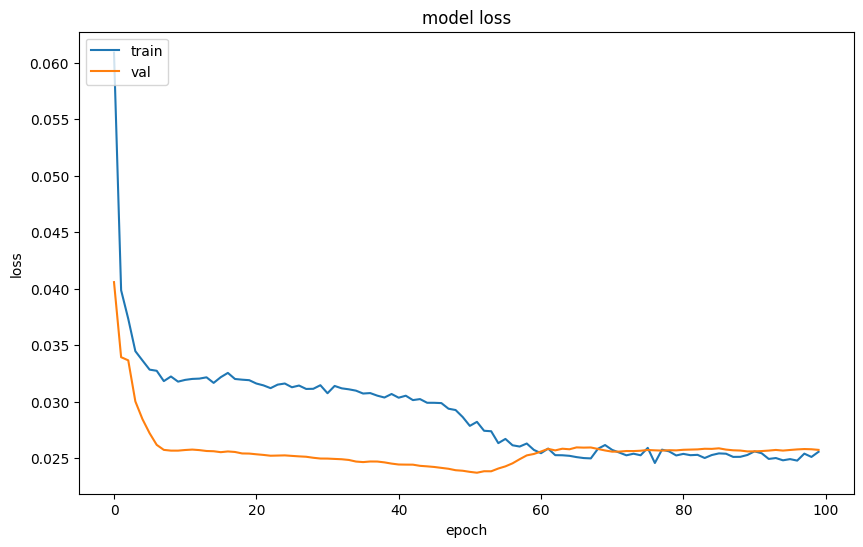

In [114]:
plt.plot(history.history['loss'])  # plotting train loss
plt.plot(history.history['val_loss'])  # plotting validation loss

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [115]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
print(test_predict[:10])
train_pred = model.predict(trainX)
train_pred = scaler.inverse_transform(train_pred)
print(train_pred[:10])
val_pred = model.predict(valX)
val_pred = scaler.inverse_transform(val_pred)
print(train_pred[:10])


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
[[ -4.827614 ]
 [  7.230867 ]
 [  7.4725504]
 [ 22.256721 ]
 [ 32.09857  ]
 [ 75.24769  ]
 [102.23714  ]
 [109.63913  ]
 [106.33938  ]
 [104.9512   ]]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[ 46.7312   ]
 [ 21.827553 ]
 [103.618675 ]
 [ 97.20862  ]
 [111.516815 ]
 [103.262535 ]
 [105.6607   ]
 [107.54806  ]
 [ 24.584042 ]
 [  8.1396885]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[ 46.7312   ]
 [ 21.827553 ]
 [103.618675 ]
 [ 97.20862  ]
 [111.516815 ]
 [103.262535 ]
 [105.6607   ]
 [107.54806  ]
 [ 24.584042 ]
 [  8.1396885]]


In [116]:
testY_actual = testY.reshape(testY.shape[0] , 1)
testY_actual = scaler.inverse_transform(testY_actual)
print(testY_actual[:10])

[[0.0000000e+00]
 [1.0000000e-01]
 [6.5000005e+00]
 [1.1400000e+01]
 [3.7599998e+01]
 [6.9300003e+01]
 [1.3489999e+02]
 [1.2810001e+02]
 [9.4800003e+01]
 [1.0800001e+01]]


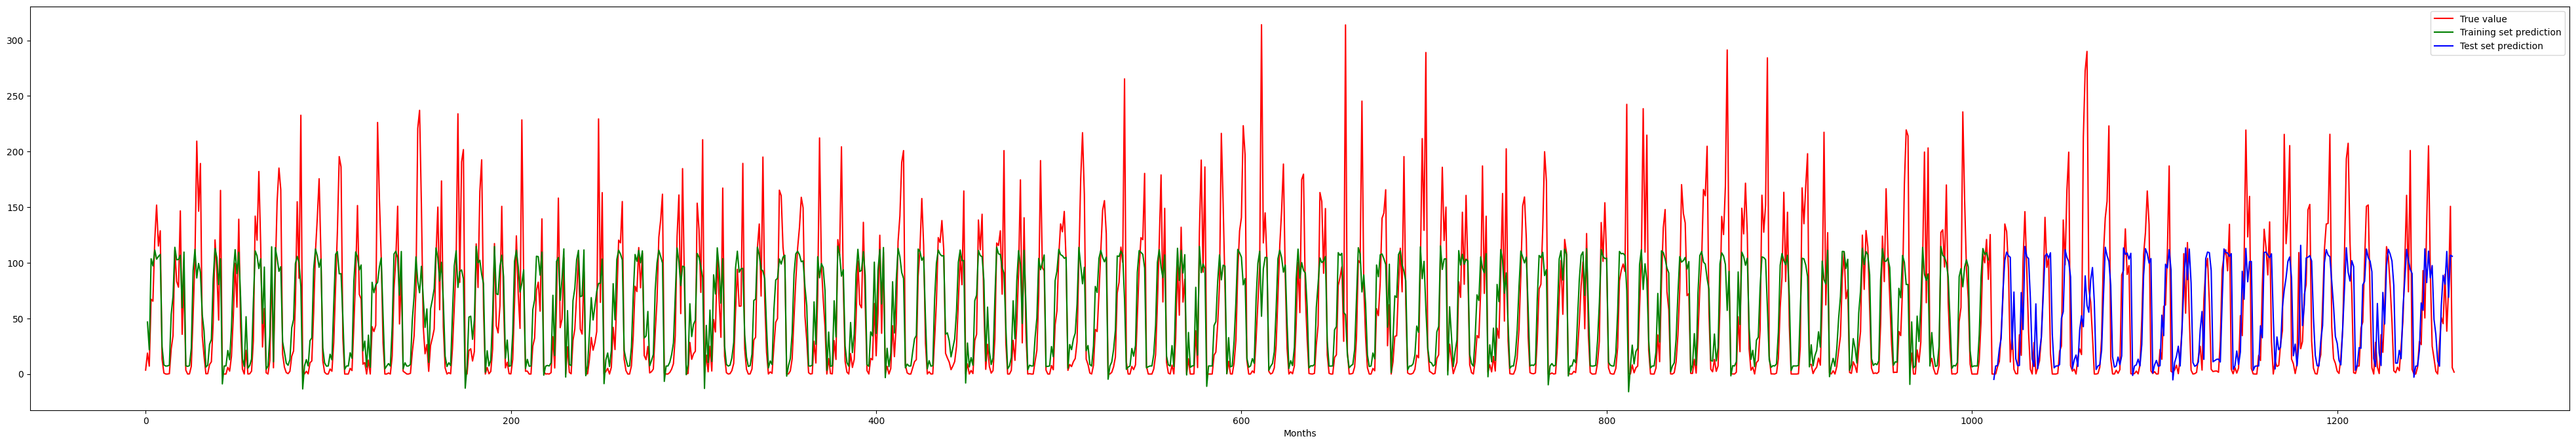

In [117]:
plot_predict_data(dataset,train_pred,test_predict)